In [294]:
import warnings
warnings.filterwarnings('ignore')

In [295]:
# universal color map for Yeo's networks

In [296]:
import seaborn as sns

def yeo_cmap(as_palette=False, networks=7):
    # ref: https://github.com/danjgale/adaptation-manifolds/blob/main/adaptman/analyses/plotting.py
    if networks == 17:
        cmap = {
            'VisCent': (120, 18, 136),
            'VisPeri': (255, 0, 2),
            'SomMotA': (70, 130, 181),
            'SomMotB': (43, 204, 165),
            'DorsAttnA': (74, 156, 61),
            'DorsAttnB': (0, 118, 17),
            'SalVentAttnA': (196, 58, 251),
            'SalVentAttnB': (255, 153, 214),
            'TempPar': (9, 41, 250),
            'ContA': (230, 148, 36),
            'ContB': (136, 50, 75),
            'ContC': (119, 140, 179),
            'DefaultA': (255, 254, 1),
            'DefaultB': (205, 62, 81),
            'DefaultC': (0, 0, 132),
            'LimbicA': (224, 248, 166),
            'LimbicB': (126, 135, 55)
        }
    else:
        cmap = {
            'Vis': (119, 20, 140),
            'SomMot': (70, 126, 175),
            'DorsAttn': (0, 117, 7),
            'SalVentAttn': (195, 59, 255),
            'Limbic': (219, 249, 165),
            'Cont': (230, 149, 33),
            'Default': (205, 65, 80)
        }
    cmap = {k: np.array(v) / 255 for k, v in cmap.items()}
    cmap['Striatum'] = (0,0,0)
    if as_palette:  return sns.color_palette(cmap.values())
    else:   return cmap

In [338]:
sns.set(style='white', context='notebook',rc={'figure.figsize': (7, 5)})

In [297]:
cmap8 = yeo_cmap(as_palette=True)
cmap8

[(0.4666666666666667, 0.0784313725490196, 0.5490196078431373),
 (0.27450980392156865, 0.49411764705882355, 0.6862745098039216),
 (0.0, 0.4588235294117647, 0.027450980392156862),
 (0.7647058823529411, 0.23137254901960785, 1.0),
 (0.8588235294117647, 0.9764705882352941, 0.6470588235294118),
 (0.9019607843137255, 0.5843137254901961, 0.12941176470588237),
 (0.803921568627451, 0.2549019607843137, 0.3137254901960784),
 (0.0, 0.0, 0.0)]

# gradients
large-scale manifold

In [298]:
import numpy as np
import pandas as pd

In [299]:
approach = 'pca'

In [300]:
RAND = 0    # random state

**if you don't apply cosine kernel while making affinity mat, you get way skewed gradient values.**

In [301]:
# this is computed based on `baseline`
ref_cmat = pd.read_csv('data/cmat/ref_mean.csv').to_numpy()

In [302]:
from brainspace.gradient import GradientMaps

In [303]:
import seaborn
from matplotlib import pyplot as plt

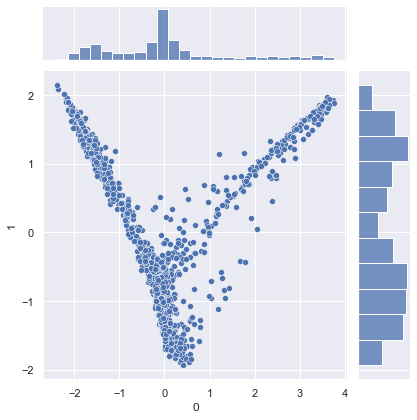

In [304]:
gref = GradientMaps(random_state=RAND, approach=approach, kernel='cosine')
# kernel needed for centered mats
gref.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref.gradients_), x=0, y=1)
plt.show()

In [305]:
def cmat_cnt(subject, epoch): return pd.read_csv('data/cmat/cnt/cnt_'+str(subject)+'_'+epoch+'.csv').to_numpy()

In [306]:
EPOCHS = ['baseline', 'early', 'late']
EPOCH_REF = 'baseline'

In [307]:
subjects = pd.read_csv('data/subjects.csv')

In [308]:
g = GradientMaps(random_state=RAND, approach=approach, alignment='procrustes', kernel='cosine')
g.fit([cmat_cnt(s, e) for e in EPOCHS for s in subjects.int_id], reference=gref.gradients_)
np.stack(g.aligned_).shape

(108, 1012, 10)

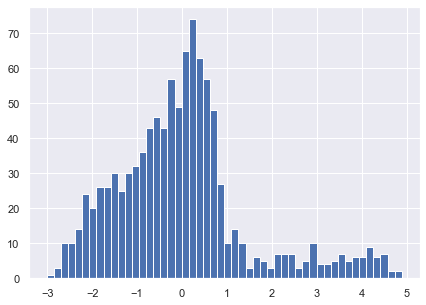

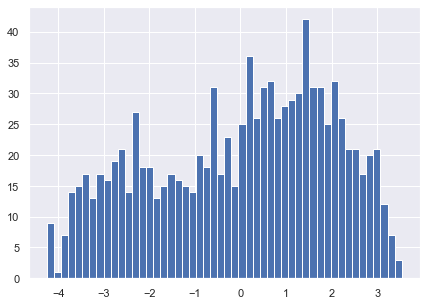

In [309]:
plt.hist(g.aligned_[0][:, 0], bins=50) # grad1
plt.show()
plt.hist(g.aligned_[0][:, 1], bins=50) # grad2
plt.show()

# make dataframe

In [310]:
# important: this is how the g.aligned_ list is organized
S = [1,2]
l = [(s, e) for e in EPOCHS for s in S]
print(l)
l[EPOCHS.index('late') * len(S) + S.index(2)]   # selects element for s=2, e='late'

[(1, 'baseline'), (2, 'baseline'), (1, 'early'), (2, 'early'), (1, 'late'), (2, 'late')]


(2, 'late')

In [311]:
r = pd.read_csv('data/regions_sorted.csv')

In [312]:
S = subjects.int_id.to_list()

df = pd.concat([pd.DataFrame({'subject': s, 'epoch': e,
                              'region': r['region'], '7net': r['7net'], '17net': r['17net'],
                              'g1': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 0],
                              'g2': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 1],
                              'g3': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 2], })
                for e in EPOCHS for s in S], axis=0).reset_index(drop=True)

In [313]:
df

,subject,epoch,region,7net,17net,g1,g2,g3
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117
...,...,...,...,...,...,...,...,...
109291,46,late,Right Putamen,Striatum,StriatumRight,-0.861413,-0.664291,-0.450307
109292,46,late,Right Pallidum,Striatum,StriatumRight,-0.530126,-0.774942,-0.468807
109293,46,late,Right Hippocampus,Striatum,StriatumRight,-0.938860,-0.247830,-1.223909
109294,46,late,Right Amygdala,Striatum,StriatumRight,-1.114832,-0.355354,-1.374354


In [314]:
# make use of palette

In [315]:
names7nets = r['7net'].unique().tolist()

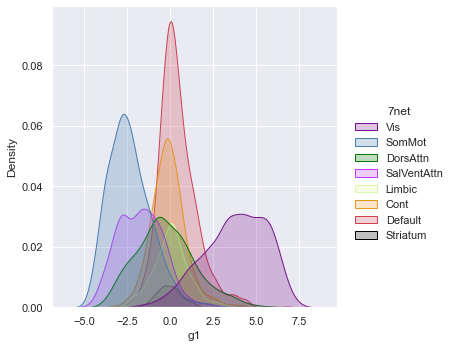

In [316]:
seaborn.displot(df.sample(10_000), x='g1', hue='7net', kind='kde', fill=True,
                palette=cmap8,
                hue_order=names7nets,
                )
plt.show()
# plt.savefig("sample10_000.svg", format="svg")

In [317]:
# this is the 3d plot. it would mess up the notebook if run
# fig = px.scatter_3d(df.sample(1000), x='g1', y='g2', z='g3', color='label', opacity=.4)
# fig.update_traces(marker_size=3)
# fig.show()

eccentricity
the Euclidean distance from the manifold center.
$Ecc = \sqrt{\sum_{\substack{i=1}}^4 G_i^2}$

In [318]:
df['ecc'] = df.apply(lambda r: np.sqrt(np.sum(g**2 for g in r[-3:])), axis=1)

In [319]:
df

,subject,epoch,region,7net,17net,g1,g2,g3,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,1.598490
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,1.827782
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,1.954351
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,3.142568
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,1.268644
...,...,...,...,...,...,...,...,...,...
109291,46,late,Right Putamen,Striatum,StriatumRight,-0.861413,-0.664291,-0.450307,1.177324
109292,46,late,Right Pallidum,Striatum,StriatumRight,-0.530126,-0.774942,-0.468807,1.049451
109293,46,late,Right Hippocampus,Striatum,StriatumRight,-0.938860,-0.247830,-1.223909,1.562316
109294,46,late,Right Amygdala,Striatum,StriatumRight,-1.114832,-0.355354,-1.374354,1.804986


In [320]:
# df.to_csv('data/gradients.csv', index=False)

average

In [321]:
df_mean = df.groupby(['region', 'epoch', '7net', '17net']).agg('mean').drop('subject', axis=1).reset_index()
df_mean

,region,epoch,7net,17net,g1,g2,g3,ecc
0,7Networks_LH_Cont_Cing_1,baseline,Cont,SalVentAttnB,-1.568082,-0.292681,-0.214813,2.021287
1,7Networks_LH_Cont_Cing_1,early,Cont,SalVentAttnB,-1.635978,0.037227,-0.567208,2.298056
2,7Networks_LH_Cont_Cing_1,late,Cont,SalVentAttnB,-1.657511,0.038653,-0.614793,2.245801
3,7Networks_LH_Cont_Cing_2,baseline,Cont,ContC,0.483634,-1.805169,-0.963203,2.474936
4,7Networks_LH_Cont_Cing_2,early,Cont,ContC,0.398380,-1.651304,-1.331622,2.381022
...,...,...,...,...,...,...,...,...
3031,Right Putamen,early,Striatum,StriatumRight,-0.689255,-0.110267,-0.145195,1.166278
3032,Right Putamen,late,Striatum,StriatumRight,-0.939216,-0.178111,-0.185569,1.369881
3033,Right Thalamus,baseline,Striatum,StriatumRight,-0.216845,-0.441681,-0.152570,1.117756
3034,Right Thalamus,early,Striatum,StriatumRight,-0.242206,-0.229092,-0.132197,1.109874


In [322]:
# caution: `groupby` changes regions' ordering. This doesn't start with `LH_Vis`
df_mean = df_mean.set_index('region').loc[pd.Series(r['region'])].reset_index()
df_mean.head()

,region,epoch,7net,17net,g1,g2,g3,ecc
0,7Networks_LH_Vis_1,baseline,Vis,DorsAttnA,0.714618,0.179757,0.540071,1.793869
1,7Networks_LH_Vis_1,early,Vis,DorsAttnA,0.682796,-0.116861,0.256490,1.535199
2,7Networks_LH_Vis_1,late,Vis,DorsAttnA,0.278858,-0.245021,-0.090645,1.440235
3,7Networks_LH_Vis_2,baseline,Vis,VisCent,1.241687,1.268604,0.866375,2.622879
4,7Networks_LH_Vis_2,early,Vis,VisCent,1.140651,1.299236,0.771234,2.365941


In [323]:
g1range = (-5,7)
g2range = (-5,4)
g3range = (-4.5,4)

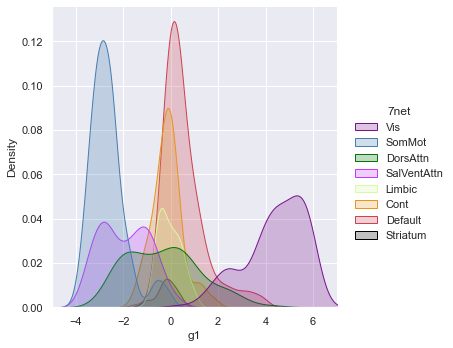

In [324]:
seaborn.displot(df_mean[df_mean.epoch=='late'], x='g1', hue='7net', kind='kde', fill=True,
                palette=cmap8,hue_order=names7nets,
                )
plt.xlim(*g1range)
plt.savefig("g1 late.svg", format="svg")

# brain plot

In [325]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot

In [326]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


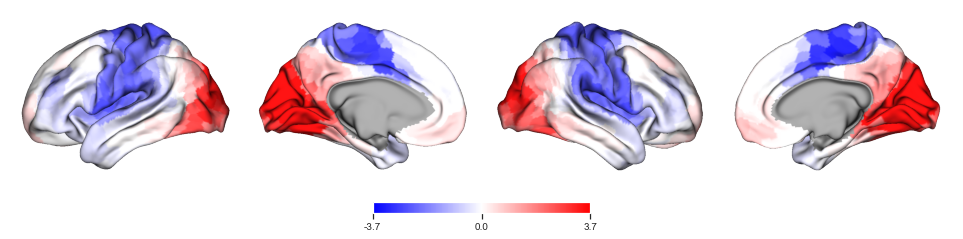

In [327]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g1']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

<AxesSubplot:>

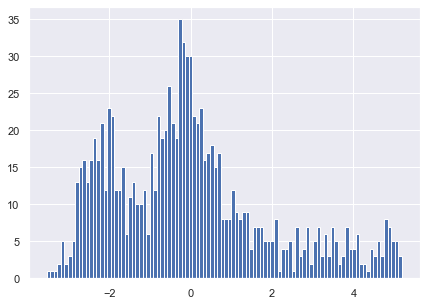

In [328]:
df_mean.loc[df_mean.epoch=='baseline', 'g1'].hist(bins=100)

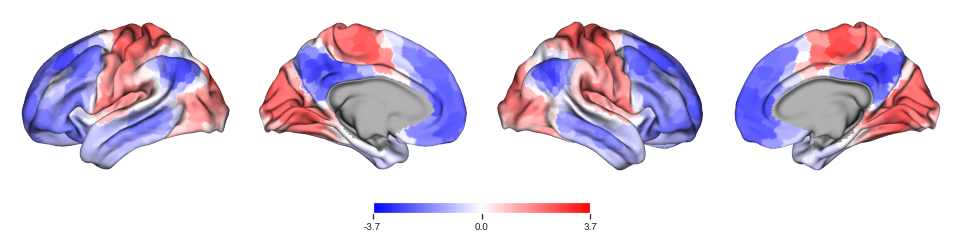

In [329]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g2']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

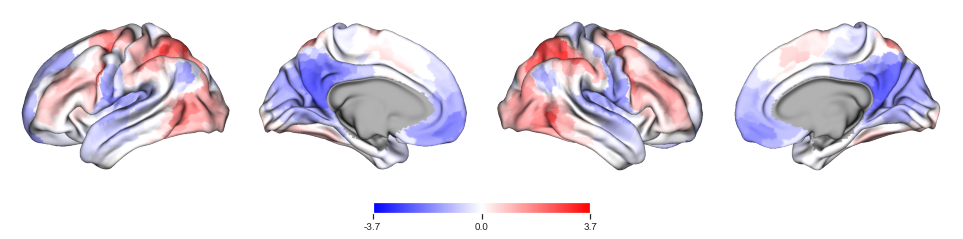

In [330]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g3']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

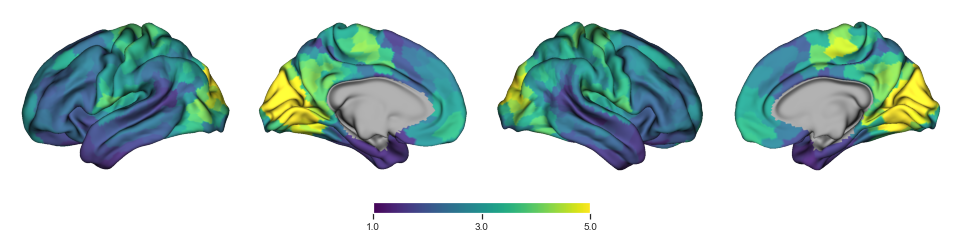

In [331]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['ecc']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True,
            cmap='viridis',color_range=(1,5))
figure = p.build()
figure.savefig('test.png', dpi=300)

# appendix scatter plots

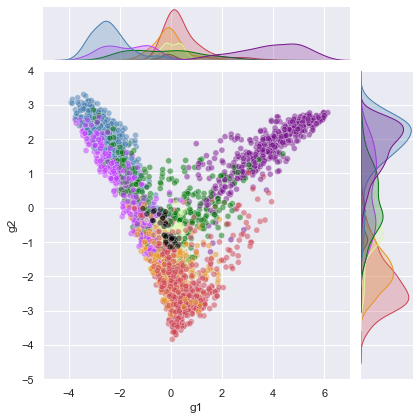

In [332]:
seaborn.jointplot(data=df_mean,
                  x='g1', y='g2',
                  xlim=g1range, ylim=g2range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False,
                       alpha=.5,
                  )
plt.savefig("g1g2.svg", format="svg")

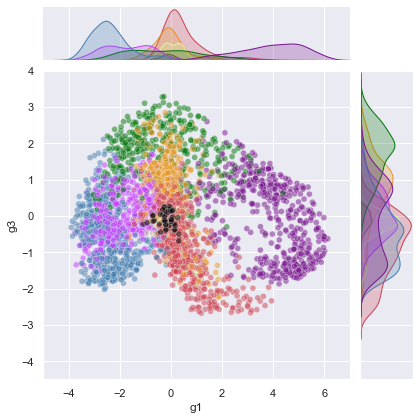

In [333]:
seaborn.jointplot(data=df_mean,
                  x='g1', y='g3',
                  xlim=g1range, ylim=g3range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False,
                       alpha=.5,
                  )
plt.savefig("g1g3.svg", format="svg")

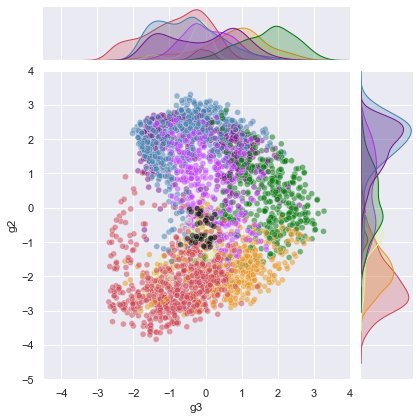

In [334]:
seaborn.jointplot(data=df_mean,
                  x='g3', y='g2',
                  xlim=g3range,
                  ylim=g2range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False, alpha=.5,
                  )
plt.savefig("g3g2.svg", format="svg")

# appendix variance cumulative explained

In [335]:
len(g.lambdas_)

108

In [336]:
e, s = 'baseline', 23
g.lambdas_[EPOCHS.index(e) * len(S) + S.index(s)]   # gives top 10 gradients

array([5.89733707, 3.42266247, 1.91803227, 1.78404697, 1.00650243,
       0.66744065, 0.59657604, 0.39942607, 0.34279046, 0.31993897])

In [337]:
df_var = pd.concat([pd.DataFrame({'subject': s, 'epoch': e,
                                  'ratio': g.lambdas_[EPOCHS.index(e) * len(S) + S.index(s)],
                                  'g': list(range(1,11)), })
                for e in EPOCHS for s in S], axis=0).reset_index(drop=True)
df_var.head()

,subject,epoch,ratio,g
0,1,baseline,4.685648,1
1,1,baseline,2.536675,2
2,1,baseline,1.978232,3
3,1,baseline,1.544357,4
4,1,baseline,0.941737,5


plot

In [353]:
sns.set(rc={'figure.figsize': (7, 8)})

In [356]:
df_var_mean = df_var.groupby(['epoch', 'g']).ratio.mean()#.unstack(0)

cumulative = False
if cumulative:  df_var_mean = df_var_mean.groupby(level=0).apply(
    lambda x: pd.Series(x.to_numpy().cumsum(), index=list(range(1,11))).rename_axis('g'))

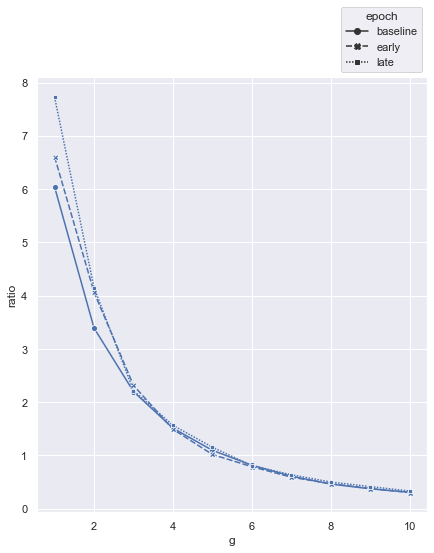

In [357]:
ax = seaborn.lineplot(x='g', y='ratio', data=df_var_mean.reset_index(), style='epoch', markers=True)
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))
plt.savefig("test.svg", format="svg")